In [1]:
import helper
import pathlib
import importlib
import ica_module
import numpy as np
import pandas as pd
from ica_module import ICA_decomposition, Means_after_masking, ICS_PATH, n_components, io_path
from random import sample
from scipy.stats import ttest_ind
from nilearn.image import load_img, index_img

### Loading DBM Maps
Here the original DBM maps are loaded. Then subjects indices for each of the PD and healthy groups were extracted from the CSV file that was provided alongside the original maps.

In [2]:
Original_DBMs = load_img("/data/origami/niusha/input/DBM_data.nii")
subject_df = pd.read_csv("/data/origami/niusha/input/subject_IDs.csv")

N = len(subject_df.ID)
ID_map = dict(zip(range(N),subject_df.ID))

Healthy_index = np.where(subject_df.PD == 0)
Healthy_subject = subject_df.ID.iloc[Healthy_index]

PD_index = np.where(subject_df.PD == 1)
PD_subject = subject_df.ID.iloc[PD_index]

In [3]:
indx = helper.outlier_indices(Original_DBMs)
indx
# Healthy_index = np.setdiff1d(Healthy_index_prior,indx)
# PD_index = np.setdiff1d(PD_index_prior,indx)
# Original_DBMs = index_img(Original_DBMs_prior, Healthy_index.tolist()+PD_index.tolist())

[]

In [4]:
# from nilearn.decomposition import CanICA
# fast_ica = CanICA(n_components=30,
#     memory="nilearn_cache", memory_level=2,
#     mask_strategy='whole-brain-template',
#     do_cca=False,
#     random_state=0,
#     standardize=True, 
#     standardize_confounds=True,
#     )
# fast_ica.fit(Original_DBMs)

# ICA_s = fast_ica.components_img_

In [5]:
# test = fast_ica.score([index_img(Original_DBMs,[1]),index_img(Original_DBMs,[2])],per_component=True)

In [6]:
# np.sum(test)

     ======== data type ======== 
 <class 'numpy.memmap'>
     ======== Maximum ========
Overall Maximum: 30.39


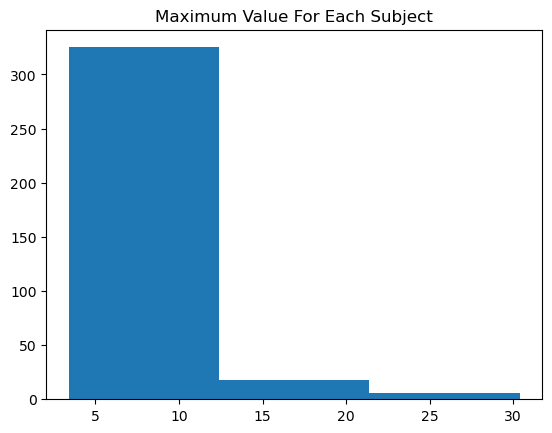

     ======== Mean ========
Overall Mean: -0.00


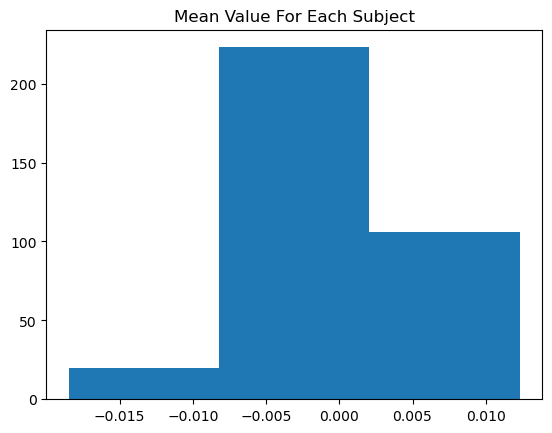

     ======== Minimum ========
Overall Minimum: -11.39


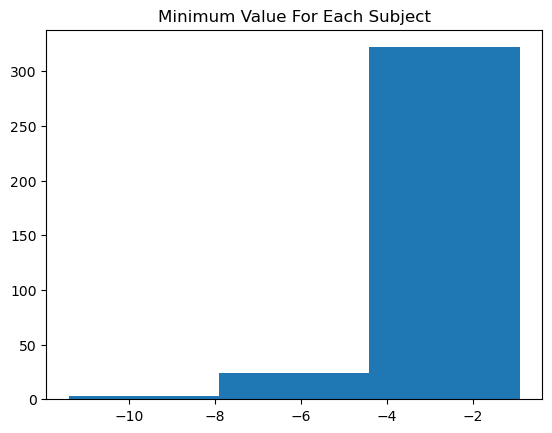

In [7]:
helper.image_report(Original_DBMs)

### PD vs Control

In this part, different variations of IC masks are used to extract the mean of ROI for each group. Then t_test was applied to means to find for which IC component the difference between PD vs control is significant.

#### Pooled Subjects ICs - Original Cohort

ICA components are extracted from the pool of subjects and masking was applied on original PD and Control cohorts.

In [8]:
importlib.reload(ica_module)

<module 'ica_module' from '/data/origami/niusha/code/local-experiment/ica_module.py'>

In [9]:
#Making related directories

whole_original_path = io_path / "whole_original_data"
whole_original_path_ICAs = whole_original_path / "ICAs"
whole_original_path_PD = whole_original_path / "PD"
whole_original_path_Healthy = whole_original_path / "Healty"

if not whole_original_path.exists():
    whole_original_path.mkdir(parents=True, exist_ok=True)
    whole_original_path_ICAs.mkdir(parents=True, exist_ok=True)
    whole_original_path_PD.mkdir(parents=True, exist_ok=True)
    whole_original_path_Healthy.mkdir(parents=True, exist_ok=True)

In [10]:
P_vals_whole_original = np.zeros((1,30))
T_vals_whole_original = np.zeros((1,30))

PD_sample = (PD_index[0]).tolist()
Healthy_sample = (Healthy_index[0]).tolist()

PD_cohort = index_img(Original_DBMs, PD_sample)
Healthy_cohort = index_img(Original_DBMs, Healthy_sample)

whole_original_ICAs = ica_module.ICA_decomposition(
    filenames=Original_DBMs,
    path=whole_original_path_ICAs,
    group="whole", 
    i="original",
    )

PD_means = ica_module.Means_after_masking(
    whole_original_ICAs,
    PD_cohort,
    path=whole_original_path_PD,
    group="PD"
    )

Healthy_means = ica_module.Means_after_masking(
    whole_original_ICAs,
    Healthy_cohort,
    path=whole_original_path_Healthy,
    group="Healthy"
    )

/data/origami/niusha/miniconda3/lib/python3.9/site-packages/joblib/memory.py:632: UserWarning: Cannot inspect object functools.partial(<function compute_multi_brain_mask at 0x7f4382221ee0>, mask_type='whole-brain'), ignore list will not work.
  return hashing.hash(filter_args(self.func, self.ignore, args, kwargs),
/data/origami/niusha/miniconda3/lib/python3.9/site-packages/nilearn/maskers/multi_nifti_masker.py:258: JobLibCollisionWarning: Cannot detect name collisions for function 'unknown'
  self.mask_img_ = self._cache(
/data/origami/niusha/miniconda3/lib/python3.9/site-packages/joblib/memory.py:810: UserWarning: Cannot inspect object functools.partial(<function compute_multi_brain_mask at 0x7f4382221ee0>, mask_type='whole-brain'), ignore list will not work.
  argument_dict = filter_args(self.func, self.ignore,
/data/origami/niusha/miniconda3/lib/python3.9/site-packages/nilearn/maskers/multi_nifti_masker.py:258: UserWarning: Persisting input arguments took 7.56s to run.
If this happe

In [11]:
np.savetxt(whole_original_path_PD / "PD_means_whole_original.txt",PD_means)
np.savetxt(whole_original_path_Healthy / "Healthy_means_whole_original.txt",Healthy_means)

Using the t-test to determine which IC component (as a mask) can separate two subject groups extracted means (PD and Healthy).

In [12]:
for i in range(30):
    T_vals_whole_original[0,i], P_vals_whole_original[0,i] = ttest_ind(PD_means[:,i], Healthy_means[:,i])

In [13]:
np.savetxt(io_path / "p_values_whole_original.txt", P_vals_whole_original)
np.savetxt(io_path / "t_stat_whole_original.txt", T_vals_whole_original)

In [14]:
# PD_means=np.loadtxt(whole_original_path_PD / "PD_means_whole_original.txt")
# Healthy_means=np.loadtxt(whole_original_path_Healthy / "Healthy_means_whole_original.txt")

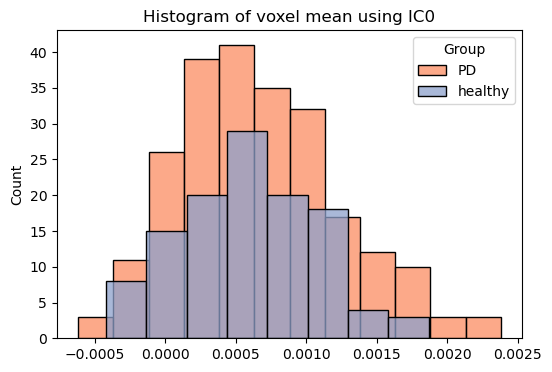

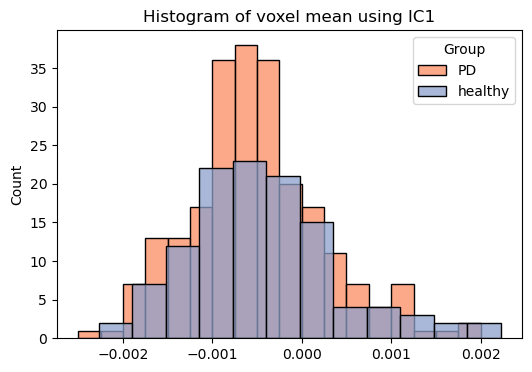

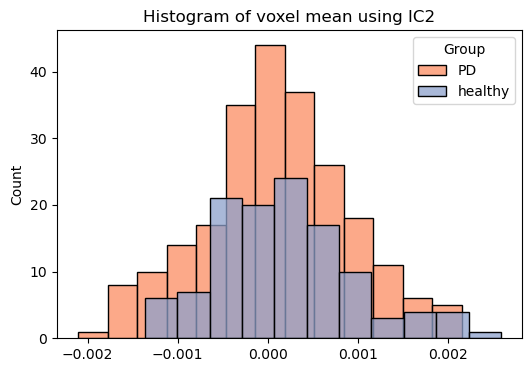

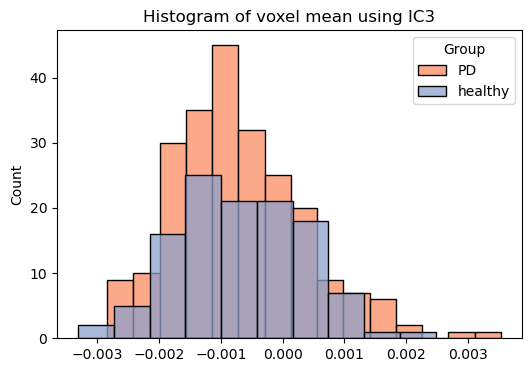

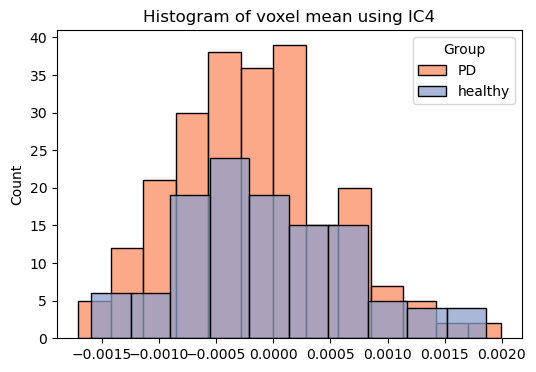

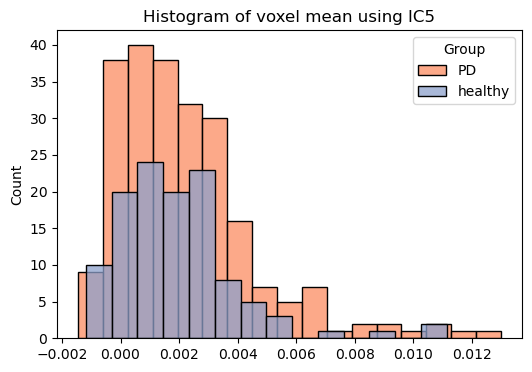

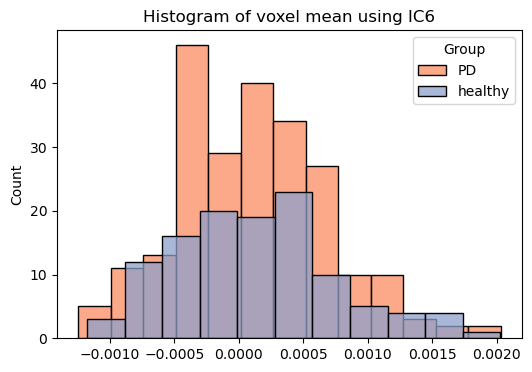

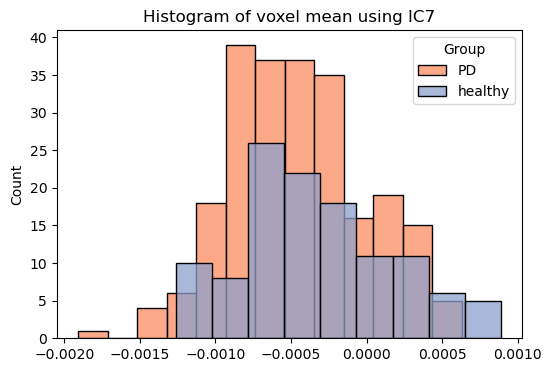

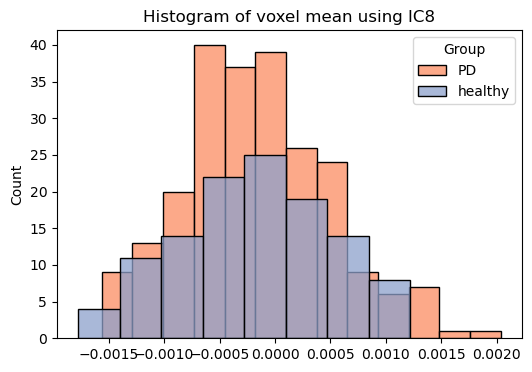

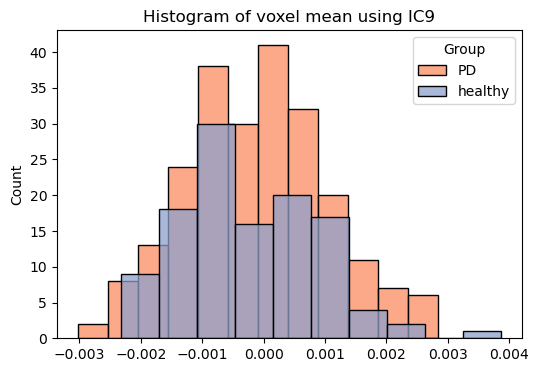

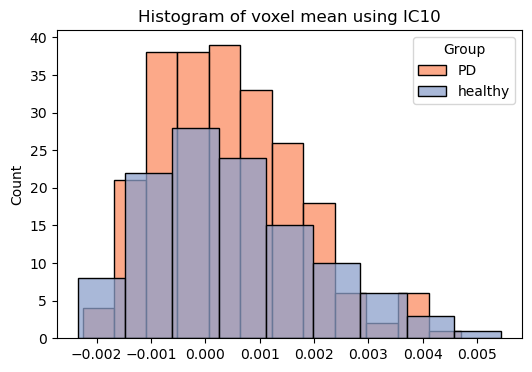

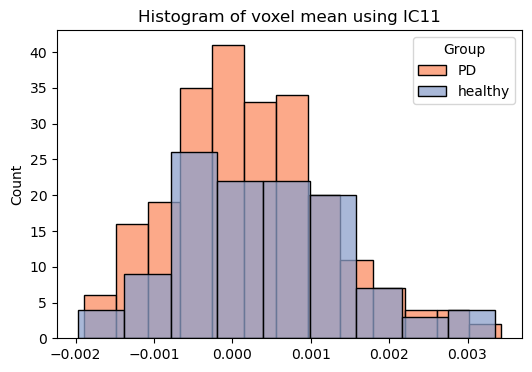

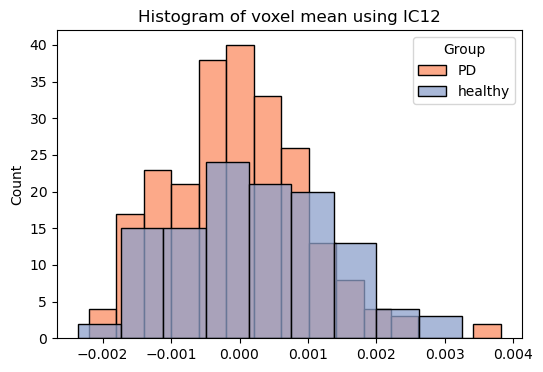

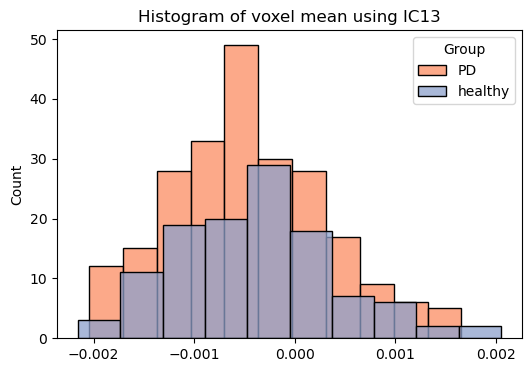

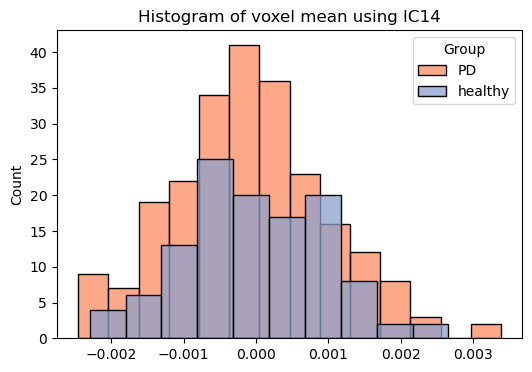

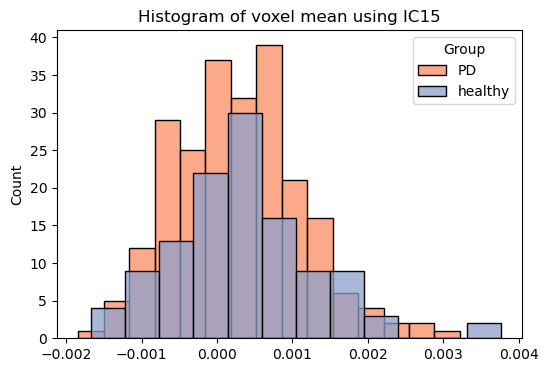

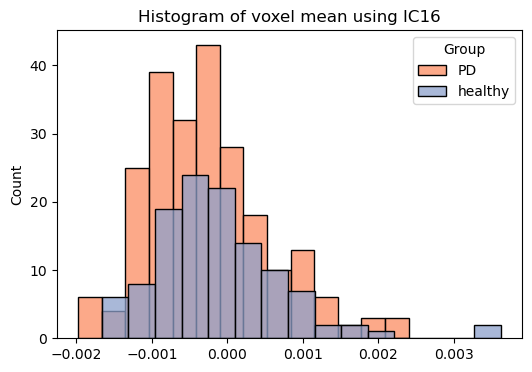

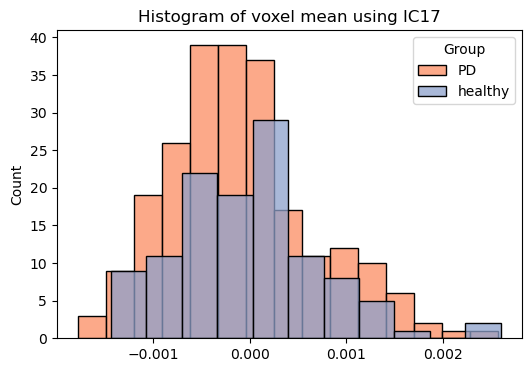

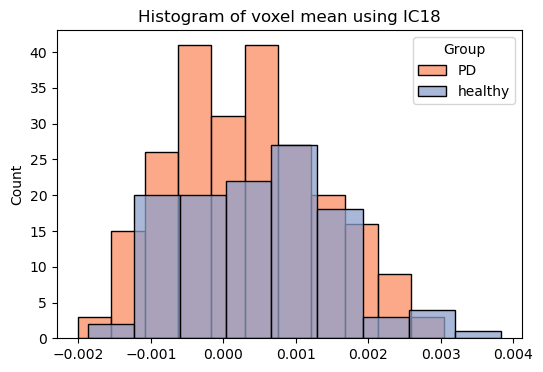

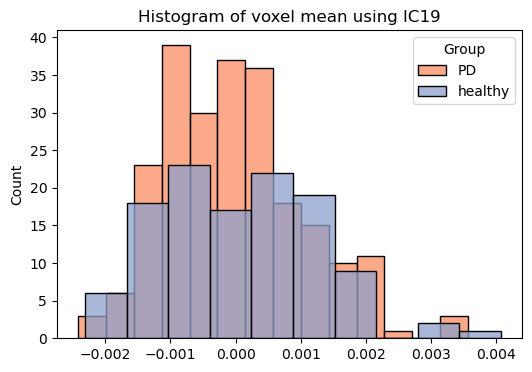

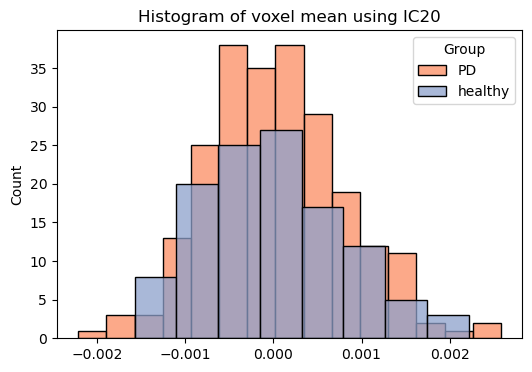

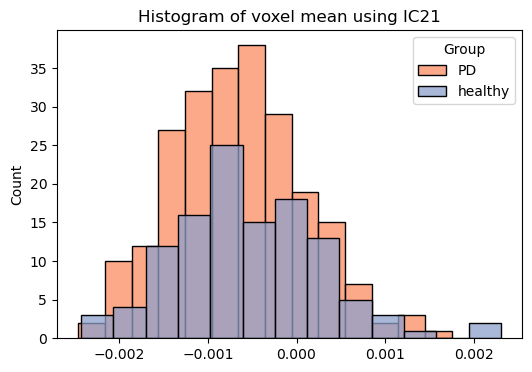

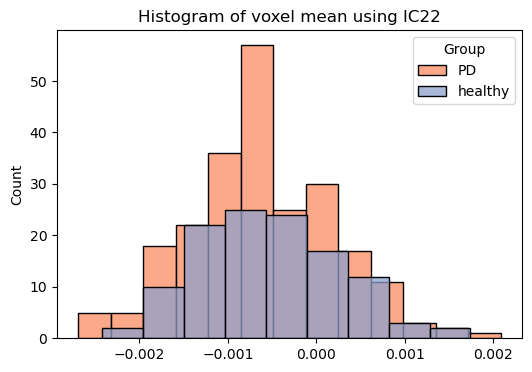

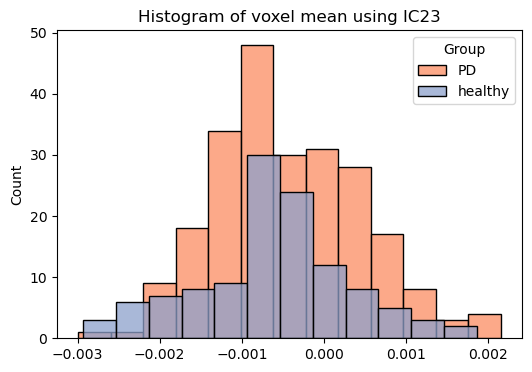

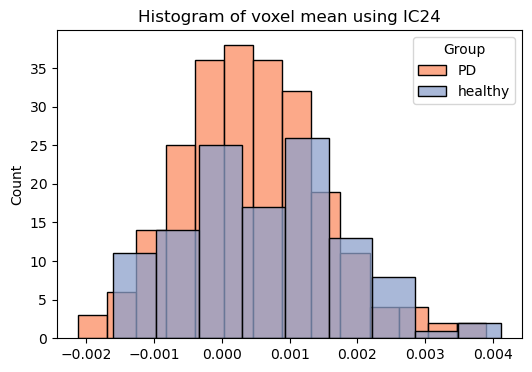

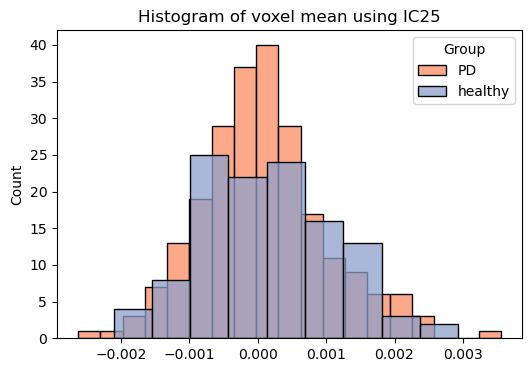

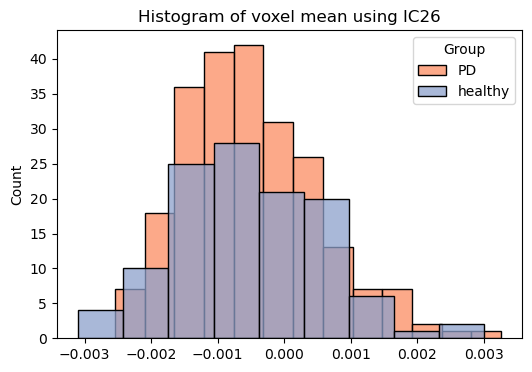

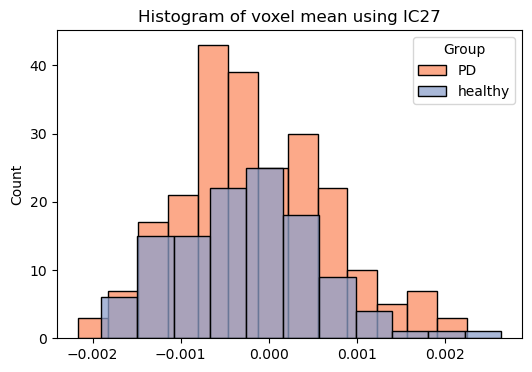

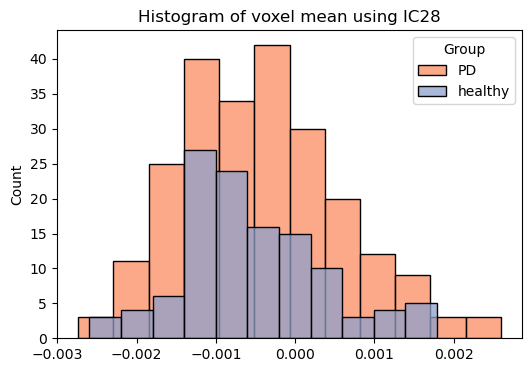

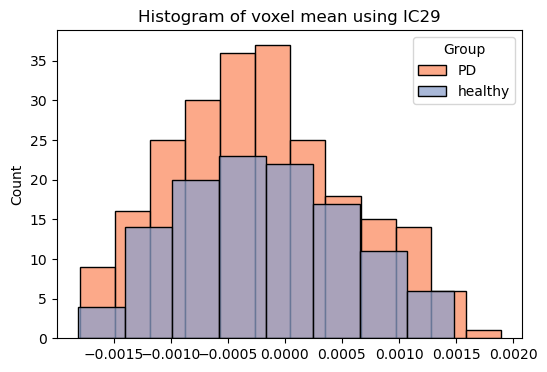

In [15]:
helper.two_array_diagrams(
    PD_means,
    Healthy_means,
    ["PD","healthy"],
    'Histogram of voxel mean using IC')

In [ ]:
# from nilearn.image import binarize_img
# from nilearn.masking import apply_mask
# from nilearn.image import iter_img
# from nilearn import masking

# size = Original_DBMs.shape[3]
# means_after_mask = np.zeros((30,size))
# for i, cur_ic in enumerate(iter_img(whole_original_ICAs)):

#     mask = binarize_img(masking.compute_brain_mask(
#         target_img=cur_ic,
#         mask_type='whole-brain',
#         ))
#     masked_data = apply_mask(imgs=Original_DBMs,mask_img=mask) # is it ok to apply on whole subjects?
#     means_after_mask[i,:] = np.nanmean(masked_data, axis=1)

#### Group Level ICs - Original Cohort

ICA componets are extracted from PD and Control groups separately and masking was applied on original PD and Control cohorts.

In [ ]:
P_vals_original = np.zeros((1,30))
T_vals_original = np.zeros((1,30))
PD_cohort = index_img(Original_DBMs, (PD_index[0]).tolist())
Healthy_cohort = index_img(Original_DBMs, (Healthy_index[0]).tolist())

PD_ICAs = ICA_decomposition(PD_cohort, "PD", "")
Healthy_ICAs = ICA_decomposition(Healthy_cohort, "Healthy", "")

PD_means = Means_after_masking(PD_ICAs,PD_cohort)
Healthy_means = Means_after_masking(Healthy_ICAs,Healthy_cohort)

for i in range(30):
    T_vals_original[0,i], P_vals_original[0,i] = ttest_ind(PD_means[:,i], Healthy_means[:,i])

In [ ]:
np.savetxt(io_path / "p_values_original.txt", P_vals_original)
np.savetxt(io_path / "t_stat_original.txt", T_vals_original)

#### Group Level ICs - Bootstrapped Cohort 

ICA components are extracted from PD and Control bootstrapped cohorts separately and masking was applied on the bootstrapped PD and Control cohorts.

In [ ]:
P_vals = np.zeros((10,30))
T_vals = np.zeros((10,30))

for j in range(10):

    PD_sample = sample((PD_index[0]).tolist(), len(PD_index[0]))
    Healthy_sample = sample((Healthy_index[0]).tolist(), len(Healthy_index[0]))

    PD_bootstrapped_cohort = index_img(Original_DBMs, PD_sample)
    Healthy_bootstrapped_cohort = index_img(Original_DBMs, Healthy_sample)

    PD_ICAs = ICA_decomposition(PD_bootstrapped_cohort, "PD", j)
    Healthy_ICAs = ICA_decomposition(Healthy_bootstrapped_cohort, "Healthy", j)

    PD_means = Means_after_masking(PD_ICAs,PD_bootstrapped_cohort)
    Healthy_means = Means_after_masking(Healthy_ICAs,Healthy_bootstrapped_cohort)

    for i in range(30):
        T_vals[j,i], P_vals[j,i] = ttest_ind(PD_means[:,i], Healthy_means[:,i])

In [ ]:
np.savetxt(io_path / "p_values.txt", P_vals)
np.savetxt(io_path / "t_stat.txt", T_vals)

#### Pooled Subjects ICs - Bootstrapped Cohort

ICA components are extracted from the pool of bootstrapped subjects and masking was applied on the bootstrapped PD and Control cohorts.

In [ ]:
P_vals_whole = np.zeros((10,30))
T_vals_whole = np.zeros((10,30))

for j in range(10):

    PD_sample = sample((PD_index[0]).tolist(), len(PD_index[0]))
    Healthy_sample = sample((Healthy_index[0]).tolist(), len(Healthy_index[0]))

    PD_bootstrapped_cohort = index_img(Original_DBMs, PD_sample)
    Healthy_bootstrapped_cohort = index_img(Original_DBMs, Healthy_sample)
    Whole_bootstrapped_cohort = index_img(Original_DBMs, PD_sample + Healthy_sample)

    whole_ICAs = ICA_decomposition(Whole_bootstrapped_cohort, "whole", j)

    PD_means = Means_after_masking(whole_ICAs,PD_bootstrapped_cohort)
    Healthy_means = Means_after_masking(whole_ICAs,Healthy_bootstrapped_cohort)

    for i in range(30):      
        T_vals_whole[j,i], P_vals_whole[j,i] = ttest_ind(PD_means[:,i], Healthy_means[:,i])

In [ ]:
np.savetxt(io_path / "p_values_whole.txt", P_vals_whole)
np.savetxt(io_path / "t_stat_whole.txt", T_vals_whole)

In [ ]:
# from nilearn.glm import threshold_stats_img

# ICA_tr = threshold_stats_img(stat_img=ICAs, threshold=3.0)
#The output is not compatible with mask and also I dont know what is the ouput of ICA. I tought it would be z stat, but when I set thr=3 I receive warning regarding the amount

In [ ]:
# from nilearn.image import load_img

# Original_DBMs = load_img("/data/origami/niusha/out/DBM_data.nii")
# whole_original_ICAs = load_img("/data/origami/niusha/code/local-experiment/io/ICAs/ICAs_whole_original.nii.gz")
# cur_img = index_img(whole_original_ICAs, 1)
# # cur_img = whole_original_ICAs
# # nifti_masker = maskers.NiftiMasker(
# #             mask_img=None,
# #             standardize='zscore',
# #             t_r=3,
# #             mask_strategy='whole-brain-template',
# #             memory="nilearn_cache",
# #             )
# from nilearn import masking
# from nilearn.masking import apply_mask
# #what should be the threshold
# mask = masking.compute_brain_mask(
#             target_img=cur_img,
#             mask_type='whole-brain',
#             )

# one_subject = index_img(Original_DBMs,1)
# masked_data = apply_mask(imgs=Original_DBMs,mask_img=mask)
# # masked_data = nifti_masker.fit_transform(one_subject)